In [3]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import torch

import numpy as np
import torchCompactRadius as tcr
from torchCompactRadius import radiusSearch, volumeToSupport
from torchCompactRadius.util import countUniqueEntries
from torchCompactRadius.radiusNaive import radiusNaive, radiusNaiveFixed
from torchCompactRadius.cppWrapper import neighborSearchSmall, neighborSearchSmallFixed
import platform
import pandas as pd
import time
from tqdm.autonotebook import tqdm
import copy
import seaborn as sns

In [6]:
import torch
import os
import platform

In [7]:
version = platform.python_version()

variant = 'py' + ''.join(version.split(".")[:-1]) + '_torch' + torch.__version__.split("+")[0].replace(".", "") + '_cu' + torch.version.cuda.replace(".", "")

print(variant)

py310_torch201_cu117


In [8]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1
11.7


In [9]:
directory = '/home/winchenbach/dev/torchCompactRadius/src/torchCompactRadius/prebuilt'
variant = 'py' + ''.join(version.split(".")[:-1]) + '_torch' + torch.__version__.split("+")[0].replace(".", "") + '_cpu'
file = os.path.join(directory, 'prebuilt') + variant + '.so'
if os.path.exists(file):
    torch.ops.load_library(file)

In [13]:
torch.ops.countNeighbors

<module 'torch.ops.countNeighbors' from 'torch.ops'>

In [2]:
def generateNeighborTestData(nx, targetNumNeighbors, dim, maxDomain_0, periodic, device):


    minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
    maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
    maxDomain[0] = maxDomain_0
    periodicity = [periodic] * dim

    extent = maxDomain - minDomain
    shortExtent = torch.min(extent, dim = 0)[0].item()
    dx = (shortExtent / nx)
    ny = int(1 // dx)
    h = volumeToSupport(dx**dim, targetNumNeighbors, dim)
    dy = dx

    # print(f"dx = {dx}, dy = {dy}, h = {h}")
    # print(f"nx = {nx}, ny = {ny}")
    # print(f"minDomain = {minDomain}, maxDomain = {maxDomain}")
    # print(f"periodicity = {periodicity}")
    # print(f"dim = {dim}")
    # print(f"device = {device}")
    # print(f"maxDomain_0 = {maxDomain_0}")
    # print(f"targetNumNeighbors = {targetNumNeighbors}")
    

    positions = []
    for d in range(dim):
        positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
    grid = torch.meshgrid(*positions, indexing = 'xy')
    positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    supports = torch.ones(positions.shape[0], device = device) * h
    ypositions = []
    for d in range(dim):
        ypositions.append(torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny, device = device))
    grid = torch.meshgrid(*ypositions, indexing = 'xy')
    y = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    ySupport = torch.ones(y.shape[0], device = device) * supports[0]
    return (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, positions.shape[0]


In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 2
periodic = False

(y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, periodic, device)
for i in range(256):
    (i_cpu, j_cpu), neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
                

In [4]:
from torch_cluster import radius

In [5]:
(y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, False, device)

In [6]:
torch.tensor(periodicity).to(device)

tensor([False, False])

In [7]:
def callRadiusNaive(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    for i in range(numTrials):
        r = radiusNaive(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, mode)
    return r

    # i, j = neighborSearchSmall(y, ySupport, positions, supports, minDomain, maxDomain, periodicTensor, 'symmetric')

def callRadiusSmall(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    for i in range(numTrials):
        r = neighborSearchSmall(y, ySupport, positions, supports, minDomain, maxDomain, torch.tensor(periodicity).to(device), mode)
    return r

def callRadiusCompact(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    for i in range(numTrials):
        r = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, mode, 'cpp')
    return r

def callRadius(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    for i in range(numTrials):
        (i,j) = radius(y, positions, supports[0], max_num_neighbors = 384)
    return (j,i)

In [8]:
from typing import Union, Tuple, Optional, List

In [15]:
def radiusSearch( 
        queryPositions : torch.Tensor,
        referencePositions : Optional[torch.Tensor],
        support : Union[float, torch.Tensor,Tuple[torch.Tensor, torch.Tensor]],
        mode : str = 'symmetric',
        domainMin : Optional[torch.Tensor] = None,
        domainMax : Optional[torch.Tensor] = None,
        periodicity : Optional[Union[bool, List[bool]]] = False,
        hashMapLength = 4096,
        algorithm: str = 'naive',
        verbose: bool = True
        ):
    assert algorithm in ['naive', 'small', 'compact'], f'algorithm = {algorithm} not supported'
    assert mode in ['symmetric', 'scatter', 'gather'], f'mode = {mode} not supported'
    assert queryPositions.shape[1] == referencePositions.shape[1] if referencePositions is not None else True, f'queryPositions.shape[1] = {queryPositions.shape[1]} != referencePositions.shape[1] = {referencePositions.shape[1]}'
    assert hashMapLength > 0, f'hashMapLength = {hashMapLength} <= 0'
    assert len(periodicity) == queryPositions.shape[1] if isinstance(periodicity, list) else True, f'len(periodicity) = {len(periodicity)} != queryPositions.shape[1] = {queryPositions.shape[1]}'
    assert domainMin.shape[0] == queryPositions.shape[1] if domainMin is not None else True, f'domainMin.shape[0] = {domainMin.shape[0]} != queryPositions.shape[1] = {queryPositions.shape[1]}'
    assert domainMax.shape[0] == queryPositions.shape[1] if domainMax is not None else True, f'domainMax.shape[0] = {domainMax.shape[0]} != queryPositions.shape[1] = {queryPositions.shape[1]}'
    assert isinstance(support, float) or support.shape[0] == queryPositions.shape[0] if isinstance(support, torch.Tensor) else True, f'support.shape[0] = {support.shape[0]} != queryPositions.shape[0] = {queryPositions.shape[0]}'
    assert support[0].shape[0] == queryPositions.shape[0] if isinstance(support, tuple) else True, f'support[0].shape[0] = {support[0].shape[0]} != queryPositions.shape[0] = {queryPositions.shape[0]}'
    assert support[1].shape[0] == referencePositions.shape[0] if isinstance(support, tuple) else True, f'support[1].shape[0] = {support[1].shape[0]} != referencePositions.shape[0] = {referencePositions.shape[0]}'



    if referencePositions is None:
        referencePositions = queryPositions

    if isinstance(support, float):
        supportRadius = support
        querySupport = None
        referenceSupport = None
    elif isinstance(support, torch.Tensor):
        supportRadius = None
        querySupport = support
        if mode == 'gather':
            referenceSupport = torch.zeros(referencePositions.shape[0], device = referencePositions.device)
        assert mode == 'gather', f'mode = {mode} != gather'
        assert querySupport.shape[0] == queryPositions.shape[0], f'querySupport.shape[0] = {querySupport.shape[0]} != queryPositions.shape[0] = {queryPositions.shape[0]}'
    elif isinstance(support, tuple):
        supportRadius = None
        querySupport = support[0]
        referenceSupport = support[1]
        assert querySupport.shape[0] == queryPositions.shape[0], f'querySupport.shape[0] = {querySupport.shape[0]} != queryPositions.shape[0] = {queryPositions.shape[0]}'
        assert referenceSupport.shape[0] == referencePositions.shape[0], f'referenceSupport.shape[0] = {referenceSupport.shape[0]} != referencePositions.shape[0] = {referencePositions.shape[0]}'
    if periodicity is not None:
        if isinstance(periodicity, bool):
            periodicTensor = [periodicity] * queryPositions.shape[1]
            if periodicity:
                assert domainMin is not None, f'domainMin = {domainMin} is None'
                assert domainMax is not None, f'domainMax = {domainMax} is None'
                assert domainMin.shape[0] == queryPositions.shape[1], f'domainMin.shape[0] = {domainMin.shape[0]} != queryPositions.shape[1] = {queryPositions.shape[1]}'
                assert domainMax.shape[0] == queryPositions.shape[1], f'domainMax.shape[0] = {domainMax.shape[0]} != queryPositions.shape[1] = {queryPositions.shape[1]}'
        else:
            periodicTensor = periodicity
            assert len(periodicTensor) == queryPositions.shape[1], f'len(periodicTensor) = {len(periodicTensor)} != queryPositions.shape[1] = {queryPositions.shape[1]}'
            if np.any(periodicTensor):
                assert domainMin is not None, f'domainMin = {domainMin} is None'
                assert domainMax is not None, f'domainMax = {domainMax} is None'
                assert domainMin.shape[0] == queryPositions.shape[1], f'domainMin.shape[0] = {domainMin.shape[0]} != queryPositions.shape[1] = {queryPositions.shape[1]}'
                assert domainMax.shape[0] == queryPositions.shape[1], f'domainMax.shape[0] = {domainMax.shape[0]} != queryPositions.shape[1] = {queryPositions.shape[1]}'    
    if supportRadius is not None:
        if algorithm == 'naive':
            if verbose:
                print('Calling radiusNaiveFixed, arguments:')
                print(f'queryPositions = {queryPositions.shape} on {queryPositions.device}')
                print(f'referencePositions = {referencePositions.shape} on {referencePositions.device}')
                print(f'supportRadius = {supportRadius}')
                print(f'periodicTensor = {periodicTensor}')
                print(f'minDomain = {minDomain.shape} on {minDomain.device}')
                print(f'maxDomain = {maxDomain.shape} on {maxDomain.device}')
            return radiusNaiveFixed(queryPositions, referencePositions, supportRadius, periodicTensor, minDomain, maxDomain)
        elif algorithm == 'small':
            if verbose:
                print('Calling neighborSearchSmallFixed, arguments:')
                print(f'queryPositions = {queryPositions.shape} on {queryPositions.device}')
                print(f'referencePositions = {referencePositions.shape} on {referencePositions.device}')
                print(f'supportRadius = {supportRadius}')
                print(f'minDomain = {minDomain.shape} on {minDomain.device}')
                print(f'maxDomain = {maxDomain.shape} on {maxDomain.device}')
                print(f'periodicTensor = {periodicTensor}')
            return neighborSearchSmallFixed(queryPositions, referencePositions, supportRadius, minDomain, maxDomain, torch.tensor(periodicTensor).to(queryPositions.device))
        elif algorithm == 'compact':
            if verbose:
                print('Calling neighborSearch, arguments:')
                print(f'queryPositions = {queryPositions.shape} on {queryPositions.device}')
                print(f'referencePositions = {referencePositions.shape} on {referencePositions.device}')
                print(f'support = {support}')
                print(f'minDomain = {minDomain.shape} on {minDomain.device}')
                print(f'maxDomain = {maxDomain.shape} on {maxDomain.device}')
                print(f'periodicity = {periodicity}')
                print(f'hashMapLength = {hashMapLength}')
                print(f'mode = {mode}')
            return neighborSearch((queryPositions, referencePositions), support, (minDomain, maxDomain), periodicity, hashMapLength, mode, 'cpp')
        else:
            raise ValueError(f'algorithm = {algorithm} not supported')
    else:
        if algorithm == 'naive':
            if verbose:
                print('Calling radiusNaive, arguments:')
                print(f'queryPositions = {queryPositions.shape} on {queryPositions.device}')
                print(f'querySupport = {querySupport.shape} on {querySupport.device}')
                print(f'referencePositions = {referencePositions.shape} on {referencePositions.device}')
                print(f'referenceSupport = {referenceSupport.shape} on {referenceSupport.device}')
                print(f'periodicTensor = {periodicTensor}')
                print(f'minDomain = {minDomain.shape} on {minDomain.device}')
                print(f'maxDomain = {maxDomain.shape} on {maxDomain.device}')
            return radiusNaive(queryPositions, referencePositions, querySupport, referenceSupport, periodicTensor, minDomain, maxDomain, mode)
        elif algorithm == 'small':
            if verbose:
                print('Calling neighborSearchSmall, arguments:')
                print(f'queryPositions = {queryPositions.shape} on {queryPositions.device}')
                print(f'querySupport = {querySupport.shape} on {querySupport.device}')
                print(f'referencePositions = {referencePositions.shape} on {referencePositions.device}')
                print(f'referenceSupport = {referenceSupport.shape} on {referenceSupport.device}' if referenceSupport is not None else None)
                print(f'minDomain = {minDomain.shape} on {minDomain.device}')
                print(f'maxDomain = {maxDomain.shape} on {maxDomain.device}')
                print(f'periodicTensor = {periodicTensor}')
                print(f'mode = {mode}')
            return neighborSearchSmall(queryPositions, querySupport, referencePositions, querySupport if referenceSupport is None else referenceSupport, minDomain, maxDomain, torch.tensor(periodicTensor).to(queryPositions.device), mode)
        elif algorithm == 'compact':
            if verbose:
                print('Calling neighborSearch, arguments:')
                print(f'queryPositions = {queryPositions.shape} on {queryPositions.device}')
                print(f'querySupport = {querySupport.shape} on {querySupport.device}')
                print(f'referencePositions = {referencePositions.shape} on {referencePositions.device}')
                print(f'referenceSupport = {referenceSupport.shape} on {referenceSupport.device}')
                print(f'periodicity = {periodicity}')
                print(f'hashMapLength = {hashMapLength}')
                print(f'mode = {mode}')
            return neighborSearch((queryPositions, referencePositions), (querySupport, referenceSupport), (minDomain, maxDomain), periodicity, hashMapLength, mode, 'cpp')
        else:
            raise ValueError(f'algorithm = {algorithm} not supported')
    pass

In [10]:
(y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, False, device)

In [11]:
def test_ij(i, j, y, positions):
    assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
    assert i.shape[0] == 11520, f'i.shape[0] = {i.shape[0]} != 11520'
    assert j.shape[0] == 11520, f'i.shape[0] = {j.shape[0]} != 11520'
    ii, ni = countUniqueEntries(i, y)
    jj, nj = countUniqueEntries(j, positions)
    assert ni.min() == ni.max(), f'ni.min() = {ni.min()} != ni.max() = {ni.max()}'
    assert ni.min() == 45, f'ni.min() = {ni.min()} != 45'
    print('Passed')

In [12]:
i, j = radiusSearch(y, positions, ySupport[0].cpu().item(), 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'naive', False)
test_ij(i, j, y, positions)
i, j = radiusSearch(y, positions, ySupport[0].cpu().item(), 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'small', False)
test_ij(i, j, y, positions)
(i, j), nl = radiusSearch(y, positions, ySupport[0].cpu().item(), 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'compact', False)
test_ij(i, j, y, positions)
i, j = radiusSearch(y, positions, (ySupport, supports), 'scatter', minDomain, maxDomain, periodicity, hashMapLength, 'naive', False)
test_ij(i, j, y, positions)
i, j = radiusSearch(y, positions, (ySupport, supports), 'scatter', minDomain, maxDomain, periodicity, hashMapLength, 'small', False)
test_ij(i, j, y, positions)
(i, j), nl = radiusSearch(y, positions, (ySupport, supports), 'scatter', minDomain, maxDomain, periodicity, hashMapLength, 'compact', False)
test_ij(i, j, y, positions)
i, j = radiusSearch(y, positions, ySupport, 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'naive', False)
test_ij(i, j, y, positions)
i, j = radiusSearch(y, positions, ySupport, 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'small', False)
test_ij(i, j, y, positions)
(i, j), nl = radiusSearch(y, positions, ySupport, 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'compact', False)
test_ij(i, j, y, positions)

Passed
Passed
Passed


Passed
Passed
Passed


Passed
Passed
Passed


In [17]:
i, j = radiusSearch(y, positions, ySupport[0].cpu().item(), 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'naive', False)
test_ij(i, j, y, positions)
i, j = radiusSearch(y, positions, ySupport[0].cpu().item(), 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'small', False)
test_ij(i, j, y, positions)
(i, j), nl = radiusSearch(y, positions, ySupport[0].cpu().item(), 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'compact', False)
test_ij(i, j, y, positions)

AssertionError: i.shape[0] = 9324 != 11520

In [17]:
i, j = radiusSearch(y, positions, ySupport[0].cpu().item(), 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'small', True)
ii, ni = countUniqueEntries(i, y)
jj, nj = countUniqueEntries(j, positions)
print(f'ni = {ni.shape, ni} ({i.shape}), nj = {nj.shape, nj} ({j.shape}) targetNumNeighbors = {targetNumNeighbors}')

Calling neighborSearchSmallFixed, arguments:
queryPositions = torch.Size([256, 2]) on cuda:0
referencePositions = torch.Size([1024, 2]) on cuda:0
supportRadius = 0.24933892488479614
minDomain = torch.Size([2]) on cuda:0
maxDomain = torch.Size([2]) on cuda:0
periodicTensor = [False, False]
ni = (torch.Size([256]), tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 4

In [20]:
(i, j), nl = radiusSearch(y, positions, ySupport[0].cpu().item(), 'gather', minDomain, maxDomain, periodicity, hashMapLength, 'compact', True)
ii, ni = countUniqueEntries(i, y)
jj, nj = countUniqueEntries(j, positions)
print(f'ni = {ni.shape, ni} ({i.shape}), nj = {nj.shape, nj} ({j.shape}) targetNumNeighbors = {targetNumNeighbors}')

Calling neighborSearch, arguments:
queryPositions = torch.Size([256, 2]) on cuda:0
referencePositions = torch.Size([1024, 2]) on cuda:0
support = 0.24933892488479614
minDomain = torch.Size([2]) on cuda:0
maxDomain = torch.Size([2]) on cuda:0
periodicity = [False, False]
hashMapLength = 1024
mode = gather
ni = (torch.Size([256]), tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 4

In [ ]:
for idx in range(len(j)):
    print(f'i = {idx}, i[i] = {i[idx]} j[i] = {j[idx]}')

In [19]:
def callNeighborSearch(algorithm, y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials):
    if algorithm == 'naive':
        return callRadiusNaive(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials)
    elif algorithm == 'small':
        return callRadiusSmall(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials)
    elif algorithm == 'compact':
        return callRadiusCompact(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials)
    elif algorithm == 'torch':
        return callRadius(y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, mode, device, numTrials)


In [20]:
device

device(type='cuda')

In [27]:
dataset = pd.DataFrame()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')
targetNumNeighbors = 50


In [28]:
ptcls = np.logspace(8, 22, 64, base = 2).astype(int)
dims = [1,2,3]
periodics = ['small', 'naive', 'compact', 'torch']
iters = 8

t_periodic = tqdm(periodics)
t_nx = tqdm(ptcls)
t_dim = tqdm(dims)
t_iter = tqdm(range(iters))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [29]:
2**18

262144

In [30]:
t_periodic.reset()
for periodic in periodics:
    t_periodic.set_description("periodic = %s" % periodic)
    t_nx.reset()
    for ptcl in ptcls:
        t_nx.set_description("ptcls = %d" % ptcl)
        t_dim.reset()
        for dim in dims:
            if ptcl > 2**19 and periodic == 'torch':
                break
            if ptcl > 2**15 and periodic == 'naive':
                break
            if ptcl > 2**17 and periodic == 'small':
                break
            
            nx = int(ptcl ** (1 / dim))
            t_dim.set_description("dim = %d, nx = %d" % (dim, nx))
            (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, False, device)
            # print(y.shape, positions.shape, ySupport.shape, supports.shape, minDomain, maxDomain, periodicity, hashMapLength)

            callNeighborSearch(periodic, y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, 'scatter', device, 1)

            # (i_cpu, j_cpu), neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
            # del i_cpu, j_cpu, neighborDict
            t_iter.reset()
            for i in range(iters):
                t_iter.set_description("i = %d" % i)
                start_time = time.time()
                # for i in range(8):
                callNeighborSearch(periodic, y, positions, ySupport, supports, periodicity, minDomain, maxDomain, hashMapLength, 'scatter', device, 1)
                # (i_cpu, j_cpu), neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')
                end_time = time.time()
                torch.cuda.empty_cache()        

                df = pd.DataFrame({
                    'ptcls': nx**dim, 'nx': nx, 'dim': dim, 'targetNumNeighbors': periodic, 
                    'time': end_time - start_time, 'device': device.type, 'algorithm': periodic
                    # 'ni_cpu.min()': ni_cpu.min().item(), 'ni_cpu.max()': ni_cpu.max().item(), 'nj_cpu.min()': nj_cpu.min().item(), 'nj_cpu.max()': nj_cpu.max().item()
                    }, index = [0])
                if i > 0:
                    dataset = pd.concat([dataset, df], ignore_index = True)
                t_iter.update()
            t_dim.update()
        t_nx.update()
    t_periodic.update()

In [31]:
display(dataset)

,ptcls,nx,dim,targetNumNeighbors,time,device,algorithm
0,256,256,1,small,0.000662,cuda,small
1,256,256,1,small,0.000553,cuda,small
2,256,256,1,small,0.000470,cuda,small
3,256,256,1,small,0.000304,cuda,small
4,256,256,1,small,0.000446,cuda,small
...,...,...,...,...,...,...,...
3922,474552,78,3,torch,0.171056,cuda,torch
3923,474552,78,3,torch,0.167784,cuda,torch
3924,474552,78,3,torch,0.269015,cuda,torch
3925,474552,78,3,torch,0.171106,cuda,torch


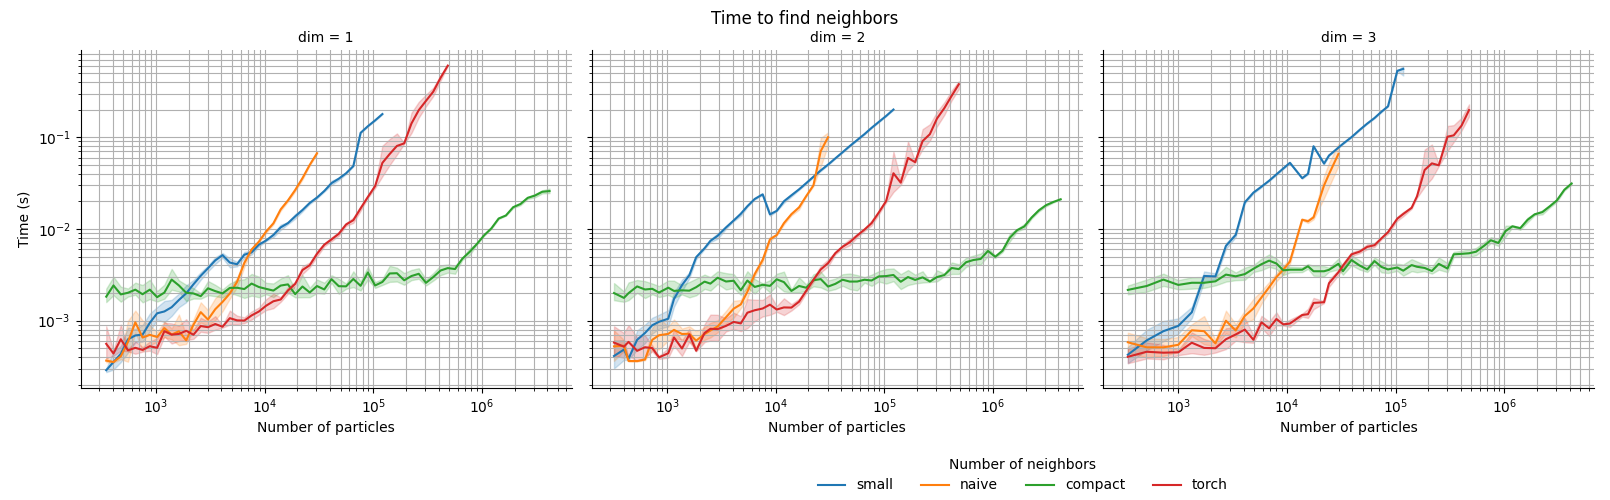

In [32]:
data = copy.deepcopy(dataset)
data = data[data['ptcls'] > 300]
data['dim'] = data['dim'].astype('category')
data['targetNumNeighbors'] = data['targetNumNeighbors'].astype('category')

g = sns.relplot(data = data, x = 'ptcls', y = 'time', hue = 'algorithm', kind = 'line', col = 'dim')

for ax in g.axes.flat:
    ax.set_xlabel('Number of particles')
    ax.set_ylabel('Time (s)')
    ax.grid(True, which='both')

g.figure.suptitle('Time to find neighbors')

sns.move_legend(g, 'center left', bbox_to_anchor=[.5, 0.05], ncols=4, title='Number of neighbors')
g.axes[0,0].set_xscale('log')
g.axes[0,0].set_yscale('log')
g.figure.tight_layout()
plt.subplots_adjust(left=0.05, right=0.99, top=0.9, bottom=0.225)

In [7]:
# import torch.autograd.profiler as profiler

# with profiler.profile(record_shapes=False, use_cuda=torch.cuda.is_available()) as prof:
#     for i in range(32):
#         with profiler.record_function("neighborSearch"):
#             (i_cpu, j_cpu), ni_cpu, nj_cpu, neighborDict = neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'scatter', 'cpp')

# print(prof.key_averages().table(sort_by="cpu_time_total"))

# # Export the trace
# # prof.export_chrome_trace("trace.json")


INFO:2024-02-13 00:11:28 864:864 init.cpp:149] If you see CUPTI_ERROR_INSUFFICIENT_PRIVILEGES, refer to https://developer.nvidia.com/nvidia-development-tools-solutions-err-nvgpuctrperm-cupti
STAGE:2024-02-13 00:11:28 864:864 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2024-02-13 00:11:33 864:864 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-02-13 00:11:33 864:864 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         neighborSearch         0.20%       8.965ms       100.00%        4.456s     139.248ms       1.045ms         0.02%        4.517s     141.171ms            32  
                neighborSearch - sortReferenceParticles         1.66%      73.884ms        59.37%        2.645s      41.336ms      37.607ms         0.83%     705.903ms      11.030ms            64  
         